<a href="https://colab.research.google.com/github/abdala9512/nlp-evaluacion-problemas-sociales/blob/main/DataPreparation_(OneHotEncoding).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation**
### One Hot Encoding Transformation

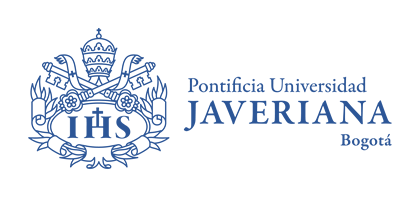

#### **Integrantes:**
- Omar Balcero
- Miguel Arquez
- Leonardo Espitia
- Laura Peñaranda

# Library Reading

In [1]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from scipy.stats import kurtosis
from scipy.stats import skew
import matplotlib.pyplot as plt
import nltk
import pdb
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import unidecode
import string
from sklearn.feature_extraction.text import CountVectorizer
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Reading

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/PNL202202/Proyecto Final/ArchivoProblemas (1).csv', delimiter=';')
df = df.assign(DESCRIPCION_LEM = df['DESCRIPCION_LEM'].fillna(df['Unnamed: 4'].apply(lambda x: np.nan if pd.isna(x) else '[' + x + ']')))
df = df.loc[df['DESCRIPCION_LEM'].isna()==False, ['TIPO','ID','DESCRIPCION','DESCRIPCION_LEM']]

stopwords_spanish = stopwords.words('spanish')
puntuacion = string.punctuation + '¿¡(“”‘’…'

In [4]:
df['descripcionlem'] = df['DESCRIPCION_LEM']\
.str.replace('[','').str.replace(']','').str.replace("'",'').str.replace(',','').str.replace('  ',' ')\
.str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')\
.str.replace(r'[0-9]','')

df['descripcionlem'] = [x.split(' ') for x in df['descripcionlem']]
df['descripcionlem'] = df['descripcionlem'].apply(lambda y: [x for x in y if (x in puntuacion)==False])
df['descripcionlem_sp'] = df['descripcionlem'].apply(lambda y: [x for x in y if (x in stopwords_spanish)==False])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [5]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform([' '.join(x) for x in df['descripcionlem']])
X_fn = vectorizer.get_feature_names_out()
X = X.toarray()

df1 = pd.DataFrame(X, columns = X_fn).merge( df['TIPO'], how = 'left', left_index=True, right_index=True)

vectorizer_sp = CountVectorizer()
X2 = vectorizer_sp.fit_transform([' '.join(x) for x in df['descripcionlem_sp']])
X2_fn = vectorizer_sp.get_feature_names_out()
X2 = X2.toarray()

df2 = pd.DataFrame(X, columns = X_fn).merge( df['TIPO'], how = 'left', left_index=True, right_index=True)

# Visualization

## **PCA**

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)

PCA_X = pca.transform(X)

[0.37540629 0.07578001]


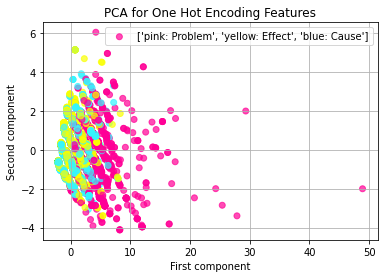

In [7]:
colors = df['TIPO'].apply(lambda x: '#ff0096' if x == 'Problem' else ('#faff00' if x == 'Effect' else '#35f5ff'))

plt.scatter(PCA_X[:,0], PCA_X[:,1], c = colors, alpha = 0.7, label = ['pink: Problem', 'yellow: Effect', 'blue: Cause'])
plt.title('PCA for One Hot Encoding Features')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.legend()
plt.grid()
plt.show()

[0.05767432 0.03761015]


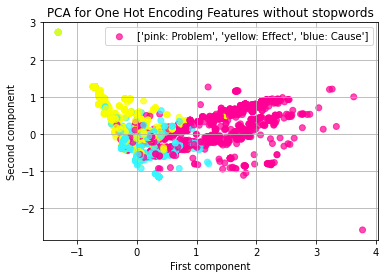

In [8]:
pca2 = PCA(n_components=2)
pca2.fit(X2)
print(pca2.explained_variance_ratio_)

PCA_X2 = pca2.transform(X2)

plt.scatter(PCA_X2[:,0], PCA_X2[:,1], c = colors, alpha = 0.7, label = ['pink: Problem', 'yellow: Effect', 'blue: Cause'])
plt.title('PCA for One Hot Encoding Features without stopwords')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.legend()
plt.grid()
plt.show()

## UMAP

In [10]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import umap

In [15]:
reducer = umap.UMAP(n_components=3, metric = 'jaccard')
X_trans = reducer.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1804: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/usr/local/lib/python3.7/dist-packages/pynndescent/pynndescent_.py:937: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  "Failed to correctly find n_neighbors for some samples."
/usr/local/lib/python3.7/dist-packages/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 1072 edges.
It has only fully disconnected 56 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  f"A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.\n"


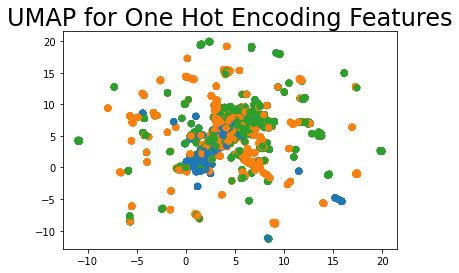

In [38]:
plt.scatter(
    X_trans[:, 0],
    X_trans[:, 1],
    c=[sns.color_palette()[x] for x in df.TIPO.map({"Problem":0, "Effect":1, "Cause":2})])
plt.title('UMAP for One Hot Encoding Features', fontsize=24);

In [39]:
reducer2 = umap.UMAP(n_components=3, metric = 'jaccard')
X_trans2 = reducer2.fit_transform(X2)

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1804: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/usr/local/lib/python3.7/dist-packages/pynndescent/pynndescent_.py:937: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  "Failed to correctly find n_neighbors for some samples."
/usr/local/lib/python3.7/dist-packages/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 3734 edges.
It has only fully disconnected 202 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  f"A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.\n"


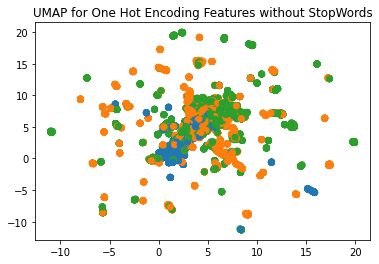

In [40]:
plt.scatter(
    X_trans2[:, 0],
    X_trans2[:, 1],
    c=[sns.color_palette()[x] for x in df.TIPO.map({"Problem":0, "Effect":1, "Cause":2})])
plt.title('UMAP for One Hot Encoding Features without StopWords');